# Outcome-informed balance plots

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import expit

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from causallib.estimation import IPW


In [2]:
def generate_data(n=1000, seed=0):
    d = 60
    rng = np.random.default_rng(seed)
    X = rng.normal(0, 0.5, size=(n, d))

    a_beta = np.concatenate((
        rng.normal(0, 0.01, size=d//4),
        rng.normal(0, 0.5, size=d//4),
        rng.normal(0, 0.01, size=d//4),
        rng.normal(0, 0.5, size=d//4),
    ))
    a_logit = X @ a_beta
    a_prop = expit(a_logit)
    a = rng.binomial(1, a_prop)

    y_beta = np.concatenate((
        rng.normal(0, 0.01, size=d//2),
        rng.normal(-2, 0.5, size=d//2),
    ))
    effect = 1
    y = X @ y_beta + a * effect + rng.normal(0, 1, size=n)
    
    X = pd.DataFrame(X, columns=[f"x{i:02d}" for i in range(X.shape[1])])
    a = pd.Series(a, name="a")
    y = pd.Series(y, name="y")
    return X, a, y

In [3]:
X, a, y = generate_data()
X.join(a).join(y)

,x00,x01,x02,x03,x04,x05,x06,x07,x08,x09,...,x52,x53,x54,x55,x56,x57,x58,x59,a,y
0,0.062865,-0.066052,0.320211,0.052450,-0.267835,0.180798,0.652000,0.473540,-0.351868,-0.632711,...,-0.002227,0.328237,-0.644181,0.197561,0.214932,0.348021,-0.592059,-0.330851,0,-6.701799
1,-0.218218,-0.584901,0.869684,-0.247955,0.164485,-0.129286,0.791736,0.660180,0.316676,-1.101755,...,-0.037851,0.101057,0.347086,-0.379185,0.710491,0.363047,0.421866,0.582432,0,-2.816572
2,0.393794,0.422039,0.037797,-0.713387,-0.067523,-0.384757,-0.711371,0.129226,-0.284275,-0.514902,...,0.458327,0.185473,0.306595,-0.076096,-0.736944,0.514427,-0.967480,-0.119968,1,6.779806
3,-0.102261,-0.521430,0.306562,-0.100165,-0.218434,0.259921,-0.238290,0.694490,0.175728,-0.237166,...,0.602198,0.795350,-0.628069,-0.590841,-0.884256,-0.481927,-1.553168,-0.571139,1,6.019206
4,0.648458,-0.172836,0.427292,-0.244485,0.880334,0.099609,-0.191001,1.276212,-0.162236,-0.610612,...,0.319926,0.377184,-0.479467,0.281199,-0.145816,0.150646,-0.630480,0.416447,0,8.001258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.116462,-0.830722,-0.349087,-0.073964,0.552409,-0.426036,-0.180565,0.395796,0.333374,0.634334,...,-0.533624,0.004432,0.699422,0.411842,0.089336,0.233651,-0.194621,-0.154141,0,0.727265
996,-0.162503,0.009430,0.662556,0.339446,0.935749,-0.172235,-0.291505,0.241524,0.227343,0.324185,...,0.689824,-0.811861,-0.099529,1.016822,-0.199815,0.000524,-1.422131,0.731760,0,2.401245
997,-0.073930,0.198832,-0.081691,0.164979,-0.172650,0.569894,0.120989,0.695015,0.855502,0.866506,...,0.578824,0.113620,0.035084,-0.181233,-0.260885,0.791273,0.097613,-0.702257,1,-1.878199
998,-0.086514,0.963202,-0.439070,-0.773299,0.003720,-0.676077,0.708520,0.543153,0.992313,0.430708,...,0.262656,0.536888,-0.388140,-0.087551,0.051587,-0.292679,0.170999,0.328401,1,1.401488


In [4]:
ipw = IPW(LogisticRegression(penalty="none", max_iter=5000))
# ipw = IPW(LogisticRegressionCV(max_iter=5000))
ipw.fit(X, a)
w = ipw.compute_weights(X, a)

In [5]:
def calculate_asmd(X, a, w=None):
    # eps = np.finfo(X.dtypes.iloc[0]).resolution  # .eps
    eps = 1e-8
    if w is None:
        w = pd.Series(1, index=a.index)
    
    is_treated = a == 1
    x1 = sm.stats.DescrStatsW(X.loc[is_treated], weights=w.loc[is_treated])
    x0 = sm.stats.DescrStatsW(X.loc[~is_treated], weights=w.loc[~is_treated])

    x1_mean = pd.Series(x1.mean, index=X.columns)
    x0_mean = pd.Series(x0.mean, index=X.columns)
    x1_var = pd.Series(x1.var, index=X.columns)
    x0_var = pd.Series(x0.var, index=X.columns)

    # smds = (x1_mean - x0_mean) / np.sqrt(x0_var + x1_var + eps)
    smds = (x1_mean - x0_mean) / ((x0_var + x1_var + eps)**0.5)
    asmds = smds.abs()
    asmds.name = "asmd"
    return asmds

In [6]:
asmds = pd.concat({
    "weighted": calculate_asmd(X, a, w),
    "unweighted": calculate_asmd(X, a),
}, names=["adjustment", "covariate"])
asmds

adjustment  covariate
weighted    x00          0.015807
            x01          0.029745
            x02          0.036038
            x03          0.029324
            x04          0.017355
                           ...   
unweighted  x55          0.180169
            x56          0.011614
            x57          0.093725
            x58          0.081427
            x59          0.033620
Name: asmd, Length: 120, dtype: float64

In [7]:
def leave_one_out_importance(estimator, X, a, y):
    results = []

    for col in ["full"] + X.columns.tolist():
        curX = X.drop(columns=col, errors="ignore")
        curXa = curX.join(a)
        estimator.fit(curXa, y)
        y_pred = estimator.predict(curXa)
        result = {
            "covariate": col,
            "r2": r2_score(y, y_pred),
            "mse": mean_squared_error(y, y_pred),
            "mae": mean_absolute_error(y, y_pred),
        }
        results.append(result)
    results = pd.DataFrame(results)
    return results

def relative_explained_variation(estimator, X, a, y, metric="mse"):
    """Harrell: https://www.fharrell.com/post/addvalue/"""
    importance = leave_one_out_importance(estimator, X, a, y)
    importance = importance.set_index("covariate")
    importance = importance / importance.loc["full"]
    importance = importance.drop(index="full")
    # importance = importance[metric]
    return importance

def decrease_in_explain_variation(estimator, X, a, y, metric="mse"):
    """https://stackoverflow.com/q/31343563"""
    importance = leave_one_out_importance(estimator, X, a, y)
    importance = importance.set_index("covariate")
    importance = (importance.loc["full"]-importance) / importance.loc["full"]
    importance = importance.drop(index="full")
    # importance = importance[metric]
    importance = importance.abs()
    return importance


In [8]:
# i = leave_one_out_importance(LinearRegression(), X, a, y)
# i = i.set_index("covariate")
# i
# relative_explained_variation(LinearRegression(), X, a, y)
feature_importance = decrease_in_explain_variation(LinearRegression(), X, a, y)
feature_importance.head()

,r2,mse,mae
covariate,,,
x00,5.097018e-05,0.001549,0.000339
x01,6.246515e-07,0.000019,0.000031
x02,5.112378e-05,0.001554,0.000621
x03,8.640311e-08,0.000003,0.000047
x04,2.284836e-05,0.000695,0.000077


In [9]:
plot_data = asmds.reset_index().merge(
    feature_importance.reset_index(), on="covariate",
)
plot_data

,adjustment,covariate,asmd,r2,mse,mae
0,weighted,x00,0.015807,5.097018e-05,0.001549,0.000339
1,weighted,x01,0.029745,6.246515e-07,0.000019,0.000031
2,weighted,x02,0.036038,5.112378e-05,0.001554,0.000621
3,weighted,x03,0.029324,8.640311e-08,0.000003,0.000047
4,weighted,x04,0.017355,2.284836e-05,0.000695,0.000077
...,...,...,...,...,...,...
115,unweighted,x55,0.180169,3.370652e-02,1.024676,0.426962
116,unweighted,x56,0.011614,2.034189e-02,0.618392,0.285100
117,unweighted,x57,0.093725,4.718136e-02,1.434311,0.581780
118,unweighted,x58,0.081427,5.523416e-02,1.679115,0.669075


In [10]:
def slope_balance(
    plot_data, 
    opacity=False, 
    pointsize=False, 
    importance_metric="mse",
    legend=True,
    threshold=None, ax=None
):
    p = so.Plot(
        data=plot_data,
        x="adjustment",
        y="asmd",
        group="covariate",
        alpha=importance_metric if opacity else None,
    ).add(
        so.Lines(),
        linewidth=importance_metric if pointsize else None,
        legend=legend,
    ).add(
        # so.Dot(pointsize=3 if not pointsize else None),
        so.Dot() if pointsize else so.Dot(pointsize=3),
        pointsize=importance_metric if pointsize else None,
        legend=legend,
    ).scale(
        x=so.Nominal(order=["unweighted", "weighted"]),
    ).label(
        x="",
        y="Absolute standardized mean difference",
    ).theme(
        sns.axes_style("white")
    ).limit(
        x=(-0.1, 1.1)
    )
    if threshold is not None:
        ax.axhline(0.1, linestyle="--", color="0.6", zorder=0)
    if ax is not None:
        p = p.on(ax).plot()

    return p

In [11]:
def scatter_balance(
    plot_data, 
    opacity=False, 
    pointsize=False, 
    importance_metric="mse",
    legend=True,
    threshold=None, ax=None
):
    plot_data = plot_data.pivot_table(
        # values=["asmd", "mse"]
        values="asmd",
        index="covariate",
        columns="adjustment"
    ).merge(
        plot_data.query("adjustment=='weighted'").drop(
            columns=["adjustment", "asmd"]
        ),
        left_index=True,
        right_on="covariate",
    )
    p = so.Plot(
        data=plot_data,
        x="unweighted",
        y="weighted",
        alpha=importance_metric if opacity else None,
        pointsize=importance_metric if pointsize else None,
    ).add(
        # so.Dot(pointsize=3 if not pointsize else None),
        so.Dot() if pointsize else so.Dot(pointsize=3),
        legend=legend,
    ).label(
        x="Unweighted ASMD",
        y="Weighted ASMD",
    ).theme(
        sns.axes_style("white")
    )
    if opacity:
        p = p.scale(alpha=so.Continuous().tick(upto=4))
    if pointsize:
        p = p.scale(pointsize=so.Continuous().tick(upto=4))
    if threshold is not None:
        ax.axhline(0.1, linestyle="--", color="0.6", zorder=0)
        ax.axvline(0.1, linestyle="--", color="0.6", zorder=0)
    if ax is not None:
        p = p.on(ax).plot()

    return p

In [12]:
fig = mpl.pyplot.figure(figsize=(7.5, 5))
topfig, bottomfig = fig.subfigures(2, 1, hspace=0)
topaxes = topfig.subplots(1, 2)
bottomaxes = bottomfig.subplots(1, 2);
mpl.pyplot.close()

In [13]:
scatter_balance(plot_data, threshold=0.1, ax=topaxes[0])
scatter_balance(plot_data, threshold=0.1, opacity=True, pointsize=True, ax=topaxes[1])

slope_balance(plot_data, threshold=0.1, ax=bottomaxes[0])
slope_balance(plot_data, threshold=0.1, opacity=True, pointsize=True, ax=bottomaxes[1])

AttributeError: 'SubFigure' object has no attribute 'savefig'

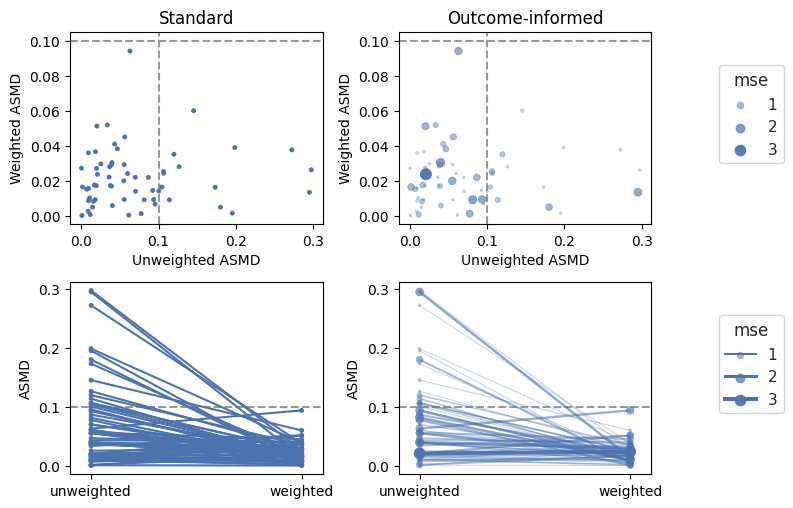

In [14]:
#| label: fig-oui-bal-plot
#| fig-cap: >
#|   Encoding covariate-outcome importance information (right) in scatter plots (top) and slope graphs (bottom).

topaxes[0].set_title("Standard")
topaxes[1].set_title("Outcome-informed")
bottomaxes[0].set_ylabel("ASMD")
bottomaxes[1].set_ylabel("ASMD")
topfig.subplots_adjust(wspace=0.3)
bottomfig.subplots_adjust(wspace=0.3)
# fig.tight_layout()
fig